## Training and inference steps

+ **This notebook aims to load the images, building the different models, train them and get the results over the test set. Also, it shows some plots of the learning phase, downloads the incorrect files for error analysis and visualises the activations of some hidden layers of the best model**

In [ ]:
#Let's mount the content from google drive
from google.colab import drive, files
drive.mount('/content/drive')

In [ ]:
#Importing libraries
import numpy as np
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential, Model
from keras import optimizers, callbacks, models
from keras.applications import vgg16
import keras
import shutil
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from sklearn.preprocessing import LabelEncoder
%matplotlib inline
np.random.seed(42)

In [ ]:
#Unzipping the images from our google drive to our local filesystem
!unzip '/content/drive/My Drive/IMAGENES_TFM_990x990.zip'

In [ ]:
#Let's set the GPU environment for the training phase. Also, we set the memory to grow as much as possible
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## TRAINING PHASE

### *To avoid Google Collab to disconnect (useful for long trainings)*
+ _Copy the next code into the Console tab after pressing Ctrl+Shift+I:_


function ClickConnect(){
    console.log("Clicked on connect button"); 
    document.querySelector("colab-connect-button").click()
}
setInterval(ClickConnect,60000)

### Builiding the models
1.   Basic CNN
2.   VGG16
3.   VGG16 + Fine Tuning

#### *BASIC CNN*

In [ ]:
#Let's rescale the images and set the rotation range for training images as 360º
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=360)
val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
#Loading the images from directories, setting some hyperparametrs and building the generator for train and val
batch_size_train = 5
batch_size_val= 5
n_epochs = 100

train_generator = train_datagen.flow_from_directory(
        '/content/TRAIN/',target_size=(990, 990),color_mode="rgb",
        batch_size=batch_size_train,
        shuffle=True,
        class_mode='categorical')
val_generator = val_datagen.flow_from_directory(
        '/content/VAL/',target_size=(990, 990),color_mode="rgb",
        batch_size=batch_size_val,
        shuffle=True,
        class_mode='categorical')

In [ ]:
#Building the basic model, setting the input dimensions, setting some more hyperparameters and the path for the checkpoint
input_shape = (990, 990, 3)

model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='sigmoid'))

n_steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps_per_epoch=val_generator.n // val_generator.batch_size

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=0.00001,decay=1e-6),
              metrics=['accuracy'])

checkpoint_path = "/content/drive/My Drive/CHECKPOINTS/cnn_aug_reg_990x990_todas.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
#Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 988, 988, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 494, 494, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 492, 492, 64)      9280      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 246, 246, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 244, 244, 128)     73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 122, 122, 128)     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 120, 120, 128)    

In [ ]:
#Loading the last weights obtained from our last checkpoint
model.load_weights('/content/drive/My Drive/CHECKPOINTS/cnn_aug_reg_990x990_todas.ckpt')       

In [ ]:
#Let's train the model        
history = model.fit_generator(train_generator, steps_per_epoch=n_steps_per_epoch, epochs=n_epochs,
                              validation_data=val_generator,validation_steps=validation_steps_per_epoch,
                              verbose=1,callbacks=[cp_callback])

Epoch 1/100
1133/1133 [==============================] - 1253s 1s/step - loss: 0.3240 - accuracy: 0.8946 - val_loss: 0.0568 - val_accuracy: 0.9007

Epoch 00001: saving model to /content/drive/My Drive/CHECKPOINTS/cnn_aug_reg_990x990_todas.ckpt
Epoch 2/100
1133/1133 [==============================] - 1253s 1s/step - loss: 0.2899 - accuracy: 0.9125 - val_loss: 0.0421 - val_accuracy: 0.9081

Epoch 00002: saving model to /content/drive/My Drive/CHECKPOINTS/cnn_aug_reg_990x990_todas.ckpt
Epoch 3/100
1133/1133 [==============================] - 1257s 1s/step - loss: 0.2738 - accuracy: 0.9127 - val_loss: 0.1539 - val_accuracy: 0.9055

Epoch 00003: saving model to /content/drive/My Drive/CHECKPOINTS/cnn_aug_reg_990x990_todas.ckpt
Epoch 4/100
1133/1133 [==============================] - 1230s 1s/step - loss: 0.2544 - accuracy: 0.9147 - val_loss: 0.4577 - val_accuracy: 0.9108

Epoch 00004: saving model to /content/drive/My Drive/CHECKPOINTS/cnn_aug_reg_990x990_todas.ckpt
Epoch 5/100
1133/1133 [=

KeyboardInterrupt: ignored

In [ ]:
#To show the accuracy and loss of the training phase
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('BASIC CNN', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,n_epochs+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, n_epochs+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, n_epochs+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
#Let's save the whole model
model.save('cnn_aug_reg_990x990_ref2.h5')

#### *VGG16*

In [ ]:
#Let's rescale the images and set the rotation range for training images as 360º
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=360)
val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
#Using VGG16 model as a feature extractor. Removing last layer and freezing the weights of all layers

input_shape = (990, 990, 3)
vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False

pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])  

58892288/58889256 [==============================] - 1s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f019d933470>,input_1,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f019d943a58>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f019d943dd8>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f01911824e0>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f0191182da0>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f019111f8d0>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f019111fb70>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f0191126860>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f01911326d8>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f0191132780>,block3_conv3,False


In [ ]:
#Loading the images from directories, setting some hyperparametrs and building the generator for train and val
#Adding two dense layers after VGG16 encoder to get the correct output.
batch_size_train = 5
batch_size_val= 5
n_epochs = 100

train_generator = train_datagen.flow_from_directory(
        '/content/TRAIN/',target_size=(990, 990),color_mode="rgb",
        batch_size=batch_size_train,
        shuffle=True,
        class_mode='categorical')
val_generator = val_datagen.flow_from_directory(
        '/content/VAL/',target_size=(990, 990),color_mode="rgb",
        batch_size=batch_size_val,
        shuffle=True,
        class_mode='categorical')

input_shape = (990, 990, 3)

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='sigmoid'))

n_steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps_per_epoch=val_generator.n // val_generator.batch_size

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=0.00001,decay=1e-6),
              metrics=['accuracy'])

checkpoint_path="/content/drive/My Drive/CHECKPOINTS//tlearning_vgg_aug_reg_990x990_todas.hdf5"
cp_callback = callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_acc',
                               verbose=1, mode='max')  

Found 5668 images belonging to 2 classes.
Found 756 images belonging to 2 classes.


In [ ]:
#Loading the last weights obtained from our last checkpoint 
model=load_model('/content/drive/My Drive/CHECKPOINTS//tlearning_vgg_aug_reg_990x990_todas.hdf5')   

In [ ]:
#Let's train the model        
history = model.fit_generator(train_generator, steps_per_epoch=n_steps_per_epoch, epochs=n_epochs,
                              validation_data=val_generator,validation_steps=validation_steps_per_epoch,
                              verbose=1,callbacks=[cp_callback])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
1133/1133 [==============================] - ETA: 0s - loss: 0.3483 - accuracy: 0.8951
Epoch 00001: saving model to /content/drive/My Drive/CHECKPOINTS/tlearning_vgg_aug_reg_990x990_todas.hdf5
1133/1133 [==============================] - 2346s 2s/step - loss: 0.3483 - accuracy: 0.8951 - val_loss: 0.2974 - val_accuracy: 0.9060
Epoch 2/100
1133/1133 [==============================] - ETA: 0s - loss: 0.2967 - accuracy: 0.9076
Epoch 00002: saving model to /content/drive/My Drive/CHECKPOINTS/tlearning_vgg_aug_reg_990x990_todas.hdf5
1133/1133 [==============================] - 2356s 2s/step - loss: 0.2967 - accuracy: 0.9076 - val_loss: 0.2726 - val_accuracy: 0.9060
Epoch 3/100
1133/1133 [==============================] - ETA: 0s - loss: 0.2783 - accuracy: 0.9089
Epoch 00003: saving model to /content/drive/My Drive/CHECKPOINTS/tlearning_vgg_aug_reg_990x990_todas.hdf5
1133/1133 [============================

In [ ]:
#To show the accuracy and loss of the training phase
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('VGG16', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,n_epochs+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, n_epochs+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, n_epochs+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
#Let's save the whole model
model.save('tlearning_vgg_aug_reg_990x990_ref2.h5')

#### *VGG16 + Fine-Tuning*

In [ ]:
#Let's rescale the images and set the rotation range for training images as 360º
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=360)
val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
#Freezing the weights of all layers from the VGG16 model except last two convolutional layers

input_shape = (990, 990, 3)
vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)
vgg_model.trainable = True

set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])  

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_2,False
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0...,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0...,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0...,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0...,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0...,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0...,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0...,block3_conv3,False


In [ ]:
#Loading the images from directories, setting some hyperparametrs and building the generator for train and val
#Adding two dense layers after VGG16 encoder to get the correct output.
batch_size_train = 5
batch_size_val= 5
n_epochs = 100

train_generator = train_datagen.flow_from_directory(
        '/content/TRAIN/',target_size=(990, 990),color_mode="rgb",
        batch_size=batch_size_train,
        shuffle=True,
        class_mode='categorical')
val_generator = val_datagen.flow_from_directory(
        '/content/VAL/',target_size=(990, 990),color_mode="rgb",
        batch_size=batch_size_val,
        shuffle=True,
        class_mode='categorical')
input_shape = (990, 990, 3)

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers, callbacks


model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='sigmoid'))

n_steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps_per_epoch=val_generator.n // val_generator.batch_size

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=0.00001,decay=1e-6),
              metrics=['accuracy'])

checkpoint_path = "/content/drive/My Drive/CHECKPOINTS/tlearning_vgg_aug_reg_fine_tuning_990x990_todas.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)   

Found 5668 images belonging to 2 classes.
Found 756 images belonging to 2 classes.


In [ ]:
#Model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_4 (Model)              (None, 460800)            14714688  
_________________________________________________________________
dense_7 (Dense)              (None, 512)               235930112 
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 1026      
Total params: 250,908,482
Trainable params: 249,172,994
Non-trainable params: 1,735,488
________________________________

In [ ]:
#Loading the last weights obtained from our last checkpoint 
model.load_weights('/content/drive/My Drive/CHECKPOINTS/tlearning_vgg_aug_reg_fine_tuning_990x990_todas.ckpt')       

In [ ]:
#Let's train the model        
history = model.fit_generator(train_generator, steps_per_epoch=n_steps_per_epoch, epochs=n_epochs,
                              validation_data=val_generator,validation_steps=validation_steps_per_epoch,
                              verbose=1,callbacks=[cp_callback])

Epoch 1/100
1133/1133 [==============================] - 1744s 2s/step - loss: 0.3203 - accuracy: 0.8988 - val_loss: 0.4798 - val_accuracy: 0.9033

Epoch 00001: saving model to /content/drive/My Drive/CHECKPOINTS/tlearning_vgg_aug_reg_fine_tuning_990x990_todas.ckpt
Epoch 2/100
1133/1133 [==============================] - 1730s 2s/step - loss: 0.2476 - accuracy: 0.9176 - val_loss: 0.0307 - val_accuracy: 0.9128

Epoch 00002: saving model to /content/drive/My Drive/CHECKPOINTS/tlearning_vgg_aug_reg_fine_tuning_990x990_todas.ckpt
Epoch 3/100
1133/1133 [==============================] - 1722s 2s/step - loss: 0.0933 - accuracy: 0.9696 - val_loss: 0.0018 - val_accuracy: 0.9840

Epoch 00003: saving model to /content/drive/My Drive/CHECKPOINTS/tlearning_vgg_aug_reg_fine_tuning_990x990_todas.ckpt
Epoch 4/100
1133/1133 [==============================] - 1722s 2s/step - loss: 0.0377 - accuracy: 0.9917 - val_loss: 1.1215 - val_accuracy: 0.9774

Epoch 00004: saving model to /content/drive/My Drive/C

In [ ]:
#To show the accuracy and loss of the training phase
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('VGG16 + Fine-Tuning', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,n_epochs+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, n_epochs+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, n_epochs+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
#Let's save the whole model
model.save('tlearning_vgg_aug_reg_fine_tuning_990x990_ref2.h5')

## INFERENCE PHASE

### *BASIC CNN*

In [ ]:
#Let's load the Basic CNN model trained for the inference phase

input_shape = (990, 990, 3)

cnn_aug_reg_990x990 = Sequential()

cnn_aug_reg_990x990.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
cnn_aug_reg_990x990.add(MaxPooling2D(pool_size=(2, 2)))

cnn_aug_reg_990x990.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn_aug_reg_990x990.add(MaxPooling2D(pool_size=(2, 2)))

cnn_aug_reg_990x990.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn_aug_reg_990x990.add(MaxPooling2D(pool_size=(2, 2)))

cnn_aug_reg_990x990.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn_aug_reg_990x990.add(MaxPooling2D(pool_size=(2, 2)))

cnn_aug_reg_990x990.add(Flatten())
cnn_aug_reg_990x990.add(Dense(512, activation='relu'))
cnn_aug_reg_990x990.add(Dropout(0.3))
cnn_aug_reg_990x990.add(Dense(512, activation='relu'))
cnn_aug_reg_990x990.add(Dropout(0.3))
cnn_aug_reg_990x990.add(Dense(2, activation='sigmoid'))
cnn_aug_reg_990x990.load_weights('/content/drive/My Drive/CHECKPOINTS/cnn_aug_reg_990x990_todas.ckpt')

### *VGG16*

In [ ]:
#Let's load the VGG16 model trained for the inference phase

input_shape = (990, 990, 3)
vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False

tlearning_vgg_aug_reg_990x990 = Sequential()
tlearning_vgg_aug_reg_990x990.add(vgg_model)
tlearning_vgg_aug_reg_990x990.add(Dense(512, activation='relu', input_dim=input_shape))
tlearning_vgg_aug_reg_990x990.add(Dropout(0.3))
tlearning_vgg_aug_reg_990x990.add(Dense(512, activation='relu'))
tlearning_vgg_aug_reg_990x990.add(Dropout(0.3))
tlearning_vgg_aug_reg_990x990.add(Dense(2, activation='sigmoid'))
tlearning_vgg_aug_reg_990x990.load_weights('/content/drive/My Drive/CHECKPOINTS/tlearning_vgg_aug_reg_990x990_todas.ckpt')       

58892288/58889256 [==============================] - 2s 0us/step


### *VGG16 + Fine_Tuning*

In [ ]:
#Let's load the VGG16+Fine_Tuning model trained for the inference phase

input_shape = (990, 990, 3)
vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = True

set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

tlearning_vgg_aug_reg_fine_tuning_990x990 = Sequential()
tlearning_vgg_aug_reg_fine_tuning_990x990.add(vgg_model)
tlearning_vgg_aug_reg_fine_tuning_990x990.add(Dense(512, activation='relu', input_dim=input_shape))
tlearning_vgg_aug_reg_fine_tuning_990x990.add(Dropout(0.3))
tlearning_vgg_aug_reg_fine_tuning_990x990.add(Dense(512, activation='relu'))
tlearning_vgg_aug_reg_fine_tuning_990x990.add(Dropout(0.3))
tlearning_vgg_aug_reg_fine_tuning_990x990.add(Dense(2, activation='sigmoid'))
tlearning_vgg_aug_reg_fine_tuning_990x990.load_weights('/content/drive/My Drive/CHECKPOINTS/tlearning_vgg_aug_reg_fine_tuning_990x990_todas.ckpt')       

58892288/58889256 [==============================] - 2s 0us/step


### *BASIC CNN PERFORMANCE*

In [ ]:
#Evaluating the model in the val and test sets

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        '/content/TEST/',target_size=(990, 990),color_mode="rgb",
        class_mode='categorical',
        shuffle=False,
        batch_size=1)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
        '/content/VAL/',target_size=(990, 990),color_mode="rgb",
        class_mode='categorical',
        shuffle=False,
        batch_size=1)
validation_steps_per_epoch=val_generator.n // val_generator.batch_size
cnn_aug_reg_990x990.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=0.00001,decay=1e-6),
              metrics=['accuracy'])

Found 1135 images belonging to 2 classes.
Found 756 images belonging to 2 classes.


In [ ]:
#Validation set metrics
cnn_aug_reg_990x990.evaluate_generator(generator=val_generator,
steps=validation_steps_per_epoch)

[0.27896571159362793, 0.9391534328460693]

In [ ]:
#Predictions for the test set
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
pred_cnn_aug_reg_990x990=cnn_aug_reg_990x990.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

1135/1135 [==============================] - 40s 35ms/step


In [ ]:
predicted_class_indices_modelo1=np.argmax(pred_cnn_aug_reg_990x990,axis=1)
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions_modelo1 = [labels[k] for k in predicted_class_indices_modelo1]
true_labels=test_generator.filenames
test_labels = [fn.split('/')[1].split('.')[0].split('-')[0].strip() for fn in true_labels]

In [ ]:
#Printing the confusion matrix for test set
total_classes = len(['NOK','OK'])
level_labels = [total_classes*[0], list(range(total_classes))]

cm = metrics.confusion_matrix(y_true=test_labels, y_pred=predictions_modelo1, 
                                  labels=['NOK','OK'])
cm_frame = pd.DataFrame(data=cm,columns=pd.MultiIndex(levels=[['Predicted:'], ['NOK','OK']],codes=level_labels), index=pd.MultiIndex(levels=[['Actual:'], ['NOK','OK']], codes=level_labels)) 
print(cm_frame) 

            Predicted:      
                   NOK    OK
Actual: NOK         75    48
        OK          10  1002


In [ ]:
#Printing metrics for the test set
print('Accuracy:', np.round(metrics.accuracy_score(test_labels,predictions_modelo1),4))
print('Precision:', np.round(metrics.precision_score(test_labels,predictions_modelo1,average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(test_labels,predictions_modelo1,average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(test_labels, predictions_modelo1,average='weighted'),4))

Accuracy: 0.9489
Precision: 0.9465
Recall: 0.9489
F1 Score: 0.9447


In [ ]:
#Printing the report of sklearn
report = metrics.classification_report(y_true=test_labels, 
                                           y_pred=predictions_modelo1, 
                                           labels=['NOK','OK']) 
print(report)

              precision    recall  f1-score   support

         NOK       0.88      0.61      0.72       123
          OK       0.95      0.99      0.97      1012

    accuracy                           0.95      1135
   macro avg       0.92      0.80      0.85      1135
weighted avg       0.95      0.95      0.94      1135



### *VGG16 PERFORMANCE*

In [ ]:
#Evaluating the model in the val and test sets

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        '/content/TEST/',target_size=(990, 990),color_mode="rgb",
        class_mode='categorical',
        shuffle=False,
        batch_size=1)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
        '/content/VAL/',target_size=(990, 990),color_mode="rgb",
        class_mode='categorical',
        shuffle=False,
        batch_size=1)

validation_steps_per_epoch=val_generator.n // val_generator.batch_size
tlearning_vgg_aug_reg_990x990.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=0.00001,decay=1e-6),
              metrics=['accuracy'])

Found 1135 images belonging to 2 classes.
Found 756 images belonging to 2 classes.


In [ ]:
#Validation set metrics
tlearning_vgg_aug_reg_990x990.evaluate_generator(generator=val_generator,
steps=validation_steps_per_epoch)

Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.19766822457313538, 0.9193121790885925]

In [ ]:
#Predictions for the test set
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
pred_tlearning_vgg_aug_reg_990x990=tlearning_vgg_aug_reg_990x990.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
1135/1135 [==============================] - 354s 312ms/step


In [ ]:
predicted_class_indices_modelo2=np.argmax(pred_tlearning_vgg_aug_reg_990x990,axis=1)
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions_modelo2 = [labels[k] for k in predicted_class_indices_modelo2]
true_labels=test_generator.filenames
test_labels = [fn.split('/')[1].split('.')[0].split('-')[0].strip() for fn in true_labels]

In [ ]:
#Printing the confusion matrix for test set
total_classes = len(['NOK','OK'])
level_labels = [total_classes*[0], list(range(total_classes))]

cm = metrics.confusion_matrix(y_true=test_labels, y_pred=predictions_modelo2, 
                                  labels=['NOK','OK'])
cm_frame = pd.DataFrame(data=cm,columns=pd.MultiIndex(levels=[['Predicted:'], ['NOK','OK']],codes=level_labels), index=pd.MultiIndex(levels=[['Actual:'], ['NOK','OK']], codes=level_labels)) 
print(cm_frame)

            Predicted:      
                   NOK    OK
Actual: NOK         47    76
        OK           0  1012


In [ ]:
#Printing metrics for the test set
print('Accuracy:', np.round(metrics.accuracy_score(test_labels,predictions_modelo2),4))
print('Precision:', np.round(metrics.precision_score(test_labels,predictions_modelo2,average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(test_labels,predictions_modelo2,average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(test_labels, predictions_modelo2,average='weighted'),4))

Accuracy: 0.933
Precision: 0.9377
Recall: 0.933
F1 Score: 0.9193


In [ ]:
#Printing the report of sklearn
report = metrics.classification_report(y_true=test_labels, 
                                           y_pred=predictions_modelo2, 
                                           labels=['NOK','OK']) 
print(report)

              precision    recall  f1-score   support

         NOK       1.00      0.38      0.55       123
          OK       0.93      1.00      0.96      1012

    accuracy                           0.93      1135
   macro avg       0.97      0.69      0.76      1135
weighted avg       0.94      0.93      0.92      1135



### *VGG16 + FINE_TUNING PERFORMANCE*

In [ ]:
#Evaluating the model in the val and test sets

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        '/content/TEST/',target_size=(990, 990),color_mode="rgb",
        class_mode='categorical',
        shuffle=False,
        batch_size=1)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
        '/content/VAL/',target_size=(990, 990),color_mode="rgb",
        class_mode='categorical',
        shuffle=False,
        batch_size=1)
validation_steps_per_epoch=val_generator.n // val_generator.batch_size
tlearning_vgg_aug_reg_fine_tuning_990x990.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=0.00001,decay=1e-6),
              metrics=['accuracy'])

Found 1135 images belonging to 2 classes.
Found 756 images belonging to 2 classes.


In [ ]:
#Validation set metrics
tlearning_vgg_aug_reg_fine_tuning_990x990.evaluate_generator(generator=val_generator,
steps=validation_steps_per_epoch)

[1.5052917490265827e-07, 0.9980158805847168]

In [ ]:
#Predictions for the test set
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
pred_tlearning_vgg_aug_reg_fine_tuning_990x990=tlearning_vgg_aug_reg_fine_tuning_990x990.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
1135/1135 [==============================] - 355s 313ms/step


In [ ]:
predicted_class_indices_modelo3=np.argmax(pred_tlearning_vgg_aug_reg_fine_tuning_990x990,axis=1)
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions_modelo3 = [labels[k] for k in predicted_class_indices_modelo3]
true_labels=test_generator.filenames
test_labels = [fn.split('/')[1].split('.')[0].split('-')[0].strip() for fn in true_labels]

In [ ]:
#Printing the confusion matrix for test set
total_classes = len(['NOK','OK'])
level_labels = [total_classes*[0], list(range(total_classes))]

cm = metrics.confusion_matrix(y_true=test_labels, y_pred=predictions_modelo3, 
                                  labels=['NOK','OK'])
cm_frame = pd.DataFrame(data=cm,columns=pd.MultiIndex(levels=[['Predicted:'], ['NOK','OK']],codes=level_labels), index=pd.MultiIndex(levels=[['Actual:'], ['NOK','OK']], codes=level_labels)) 
print(cm_frame) 

            Predicted:      
                   NOK    OK
Actual: NOK        120     3
        OK           0  1012


In [ ]:
#Printing metrics for the test set
print('Accuracy:', np.round(metrics.accuracy_score(test_labels,predictions_modelo3),4))
print('Precision:', np.round(metrics.precision_score(test_labels,predictions_modelo3,average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(test_labels,predictions_modelo3,average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(test_labels, predictions_modelo3,average='weighted'),4))

Accuracy: 0.9974
Precision: 0.9974
Recall: 0.9974
F1 Score: 0.9973


In [ ]:
#Printing the report of sklearn
report = metrics.classification_report(y_true=test_labels, 
                                           y_pred=predictions_modelo3, 
                                           labels=['NOK','OK']) 
print(report)

              precision    recall  f1-score   support

         NOK       1.00      0.98      0.99       123
          OK       1.00      1.00      1.00      1012

    accuracy                           1.00      1135
   macro avg       1.00      0.99      0.99      1135
weighted avg       1.00      1.00      1.00      1135



## DOWNLOADING WRONG PREDICTIONS

In [ ]:
#Encoding the ground-truth for the test set and the predictions of the model
le = LabelEncoder()
le.fit(test_labels)
test_labels_enc = le.transform(test_labels)
predictions_labels_enc = le.transform(predictions_modelo3)

In [ ]:
#Creating the folder to store the wrong predictions
train_dir = '/content/fallos_modelo3_todas'
os.mkdir(train_dir) if not os.path.isdir(train_dir) else None

In [ ]:
#Let's iterate over predictions and copy to the folder created those not matching with ground-truth
ite=0
for i in predictions_labels_enc:
    if(i!=test_labels_enc[ite]):
        shutil.copy('/content/TEST/'+true_labels[ite], train_dir)
    ite=ite+1

In [ ]:
#Zipping and downloading
!zip -r fallos_modelo3_todas.zip '/content/fallos_modelo3_todas'
files.download('fallos_modelo3_todas.zip')

## *PLOTTING ROC CURVES*

In [ ]:
#BASIC CNN
predictions_modelo1_enc = le.transform(predictions_modelo1)
fpr, tpr, thresholds=metrics.roc_curve(test_labels_enc, predicted_class_indices_modelo1)
plt.plot(fpr, tpr)
plt.title("BASIC CNN")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

In [ ]:
#VGG16
predictions_modelo2_enc = le.transform(predictions_modelo2)
fpr, tpr, thresholds=metrics.roc_curve(test_labels_enc, predicted_class_indices_modelo2)
plt.plot(fpr, tpr)
plt.title("VGG16")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

In [ ]:
#VGG16+FINE_TUNING
predictions_modelo3_enc = le.transform(predictions_modelo3)
fpr, tpr, thresholds=metrics.roc_curve(test_labels_enc, predicted_class_indices_modelo3)
plt.plot(fpr, tpr)
plt.title("VGG16 + FINE_TUNING")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

## *INFERENCE OVER A SINGLE EXAMPLE*

(1, 990, 990, 3)


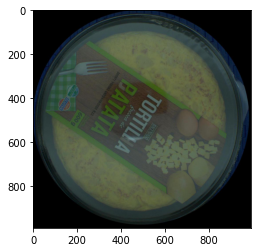

In [ ]:
#One random example in test set
sample_img_path = test_generator.filepaths[501]
sample_img = load_img(sample_img_path, target_size=(990,990))
sample_img_tensor = img_to_array(sample_img)
sample_img_tensor = np.expand_dims(sample_img_tensor, axis=0)
sample_img_tensor /= 255.

print(sample_img_tensor.shape)
plt.imshow(sample_img_tensor[0])

In [ ]:
inference=tlearning_vgg_aug_reg_fine_tuning_990x990.predict(sample_img_tensor)

In [ ]:
prediction=np.argmax(inference,axis=1)
labels = {'NOK':0,'OK':1}
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in prediction]
true_label=sample_img_path
test_label = true_label.split('/')[4].split('.')[0].split('-')[0].strip()

In [ ]:
print('PREDICTION: ',predictions)
print('GROUND-TRUTH: ',test_label)

## *VISUALIZATION OF THE ACTIVATIONS IN THE HIDDEN LAYERS*

In [ ]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in tlearning_vgg_aug_reg_fine_tuning_990x990.layers[0].layers[1:9]]
print(layer_outputs)
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=tlearning_vgg_aug_reg_fine_tuning_990x990.layers[0].layers[1].input, outputs=layer_outputs)
# This will return a list of 8 Numpy array
# one array per layer activation
activations = activation_model.predict(sample_img_tensor)

[<tf.Tensor 'block1_conv1/Relu:0' shape=(None, 990, 990, 64) dtype=float32>, <tf.Tensor 'block1_conv2/Relu:0' shape=(None, 990, 990, 64) dtype=float32>, <tf.Tensor 'block1_pool/MaxPool:0' shape=(None, 495, 495, 64) dtype=float32>, <tf.Tensor 'block2_conv1/Relu:0' shape=(None, 495, 495, 128) dtype=float32>, <tf.Tensor 'block2_conv2/Relu:0' shape=(None, 495, 495, 128) dtype=float32>, <tf.Tensor 'block2_pool/MaxPool:0' shape=(None, 247, 247, 128) dtype=float32>, <tf.Tensor 'block3_conv1/Relu:0' shape=(None, 247, 247, 256) dtype=float32>, <tf.Tensor 'block3_conv2/Relu:0' shape=(None, 247, 247, 256) dtype=float32>]


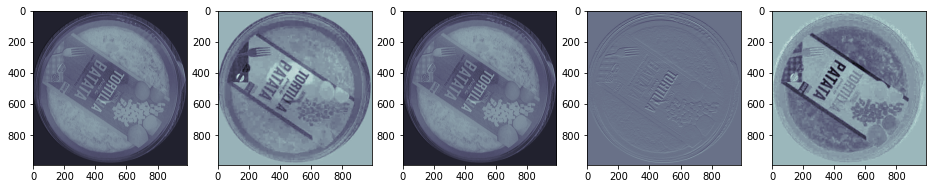

In [ ]:
ig, ax = plt.subplots(1,5, figsize=(16, 6))
ax[0].imshow(activations[0][0, :, :, 2], cmap='bone')
ax[1].imshow(activations[0][0, :, :, 5], cmap='bone')
ax[2].imshow(activations[0][0, :, :, 2], cmap='bone')
ax[3].imshow(activations[0][0, :, :, 10], cmap='bone')
ax[4].imshow(activations[0][0, :, :, 15], cmap='bone')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


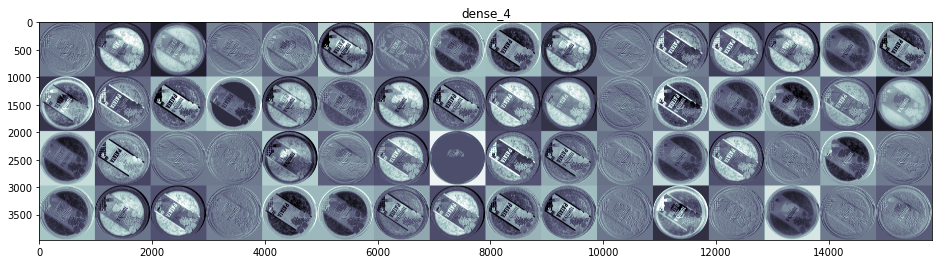

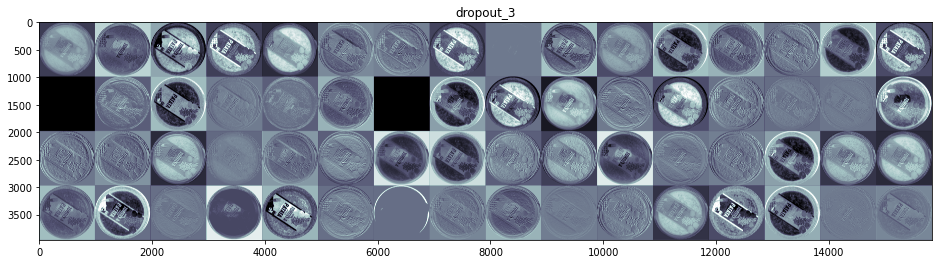

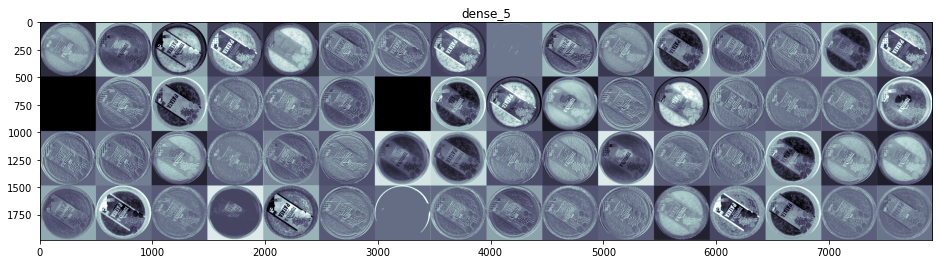

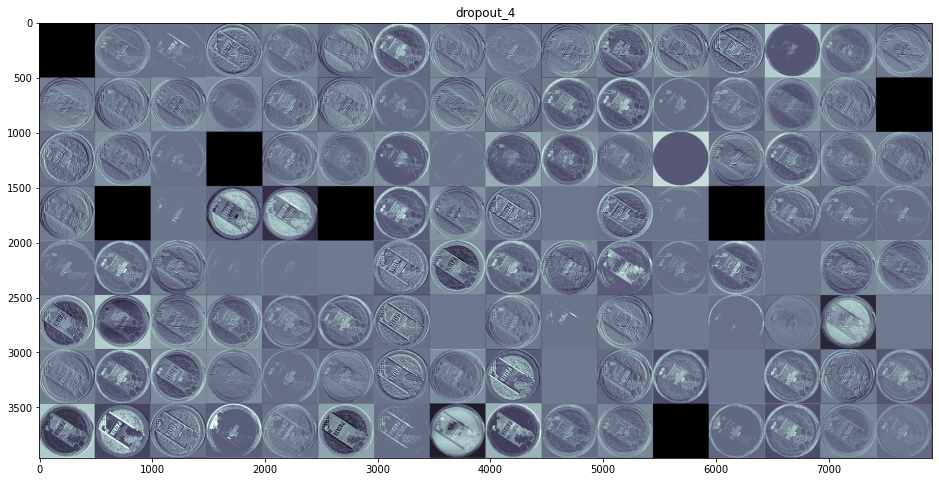

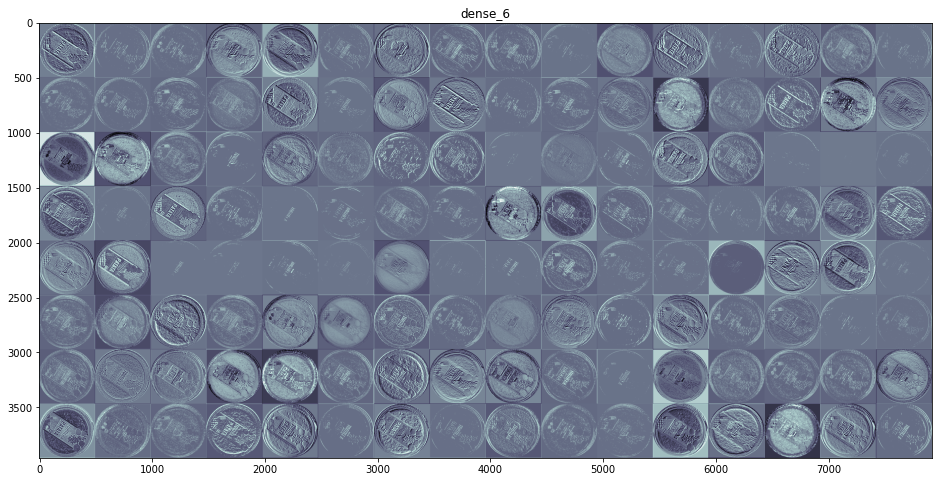

In [ ]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in tlearning_vgg_aug_reg_fine_tuning_990x990.layers[1:9]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='bone')